# VQA 시스템 구축

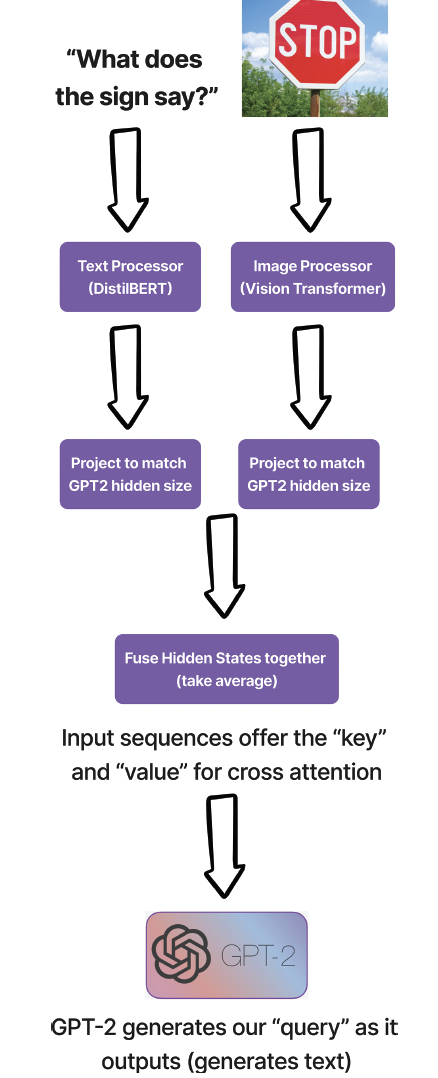

# 1. 초기화

In [1]:
BASE_DIR = "."

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
!pip install torchvision
!pip install datasets

In [4]:
###########################################
# 1-1. Google drive mount

if IN_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    
    BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/quick-start-guide-to-llms/notebooks"

In [5]:
!cd "/content/drive/MyDrive/Colab Notebooks/quick-start-guide-to-llms/notebooks"

zsh:cd:1: no such file or directory: /content/drive/MyDrive/Colab Notebooks/quick-start-guide-to-llms/notebooks


1. 필요한 라이브러리 임포트:
   - `numpy`: 수치 계산을 위한 라이브러리
   - `matplotlib.pyplot`: 데이터 시각화를 위한 라이브러리
   - `torch`: PyTorch 딥러닝 프레임워크
   - `datasets`: 데이터셋 관련 라이브러리
   - `torch.utils.data`: PyTorch의 데이터 로더 관련 모듈
   - `torch.optim`: PyTorch의 최적화 알고리즘 관련 모듈
   - `torch.nn`: PyTorch의 신경망 구성 요소 관련 모듈
   - `transformers`: Hugging Face의 Transformer 모델 관련 라이브러리

2. 디바이스 설정:
   - `torch.device('cuda' if torch.cuda.is_available() else 'cpu')`: GPU가 사용 가능한 경우 'cuda'를, 그렇지 않은 경우 'cpu'를 디바이스로 설정합니다.

3. Transformer 모델 및 관련 모듈 임포트:
   - `AutoModel`: Transformer 모델을 자동으로 로드하는 클래스
   - `ViTModel`: Vision Transformer (ViT) 모델 클래스
   - `AutoModelForCausalLM`: 인과 언어 모델링을 위한 Transformer 모델 클래스
   - `Trainer`: Hugging Face의 Trainer 클래스로, 모델 학습을 간편하게 수행할 수 있도록 도와줍니다.
   - `TrainingArguments`: 학습 관련 인자를 설정하는 클래스
   - `ViTFeatureExtractor`: ViT 모델의 입력으로 사용되는 이미지 특징 추출기
   - `AutoTokenizer`: Transformer 모델의 토크나이저를 자동으로 로드하는 클래스

이 소스코드는 PyTorch와 Hugging Face의 Transformer 라이브러리를 사용하여 딥러닝 모델을 구성하고 학습하기 위한 기본적인 설정을 하는 부분입니다. 주요 내용은 다음과 같습니다:

1. 필요한 라이브러리와 모듈을 임포트합니다.
2. GPU 사용 가능 여부에 따라 디바이스를 설정합니다.
3. Transformer 모델과 관련된 클래스들을 임포트합니다.

이 소스코드는 딥러닝 프로젝트의 시작 부분으로, 필요한 라이브러리와 모듈을 준비하고 디바이스를 설정하는 역할을 합니다. 이후에는 데이터셋 로드, 모델 구성, 학습 등의 과정이 이어질 것으로 예상됩니다.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch.nn.functional as F

import torch.nn as nn
from transformers import AutoModel, ViTModel, AutoModelForCausalLM, Trainer, TrainingArguments, ViTFeatureExtractor, AutoTokenizer

import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

이 부분은 모델 아키텍처를 정의하는 부분입니다.

1. `DECODER_MODEL`: 디코더로 사용할 모델을 지정합니다. 여기서는 'gpt2' 모델을 사용합니다.

2. `TEXT_ENCODER_MODEL`: 텍스트 인코더로 사용할 모델을 지정합니다. 'distilbert-base-uncased' 모델을 사용합니다.

3. `IMAGE_ENCODER_MODEL`: 이미지 인코더로 사용할 모델을 지정합니다. 'facebook/dino-vitb16' 모델을 사용합니다.

이 코드에서는 디코더로 GPT-2, 텍스트 인코더로 DistilBERT, 이미지 인코더로 Facebook의 DINO-ViT 모델을 사용하도록 설정하고 있습니다.

In [7]:
DECODER_MODEL = 'gpt2'
TEXT_ENCODER_MODEL = 'distilbert-base-uncased'
IMAGE_ENCODER_MODEL = "facebook/dino-vitb16"

이 부분은 모델에 사용될 토크나이저와 특징 추출기를 생성하는 코드입니다.

1. `decoder_tokenizer`: DECODER_MODEL에 해당하는 사전 학습된 토크나이저를 불러옵니다. 그리고 패딩 토큰을 EOS 토큰으로 설정합니다.

2. `image_feature_extractor`: IMAGE_ENCODER_MODEL에 해당하는 사전 학습된 ViT 특징 추출기를 불러옵니다.

3. `text_tokenizer`: TEXT_ENCODER_MODEL에 해당하는 사전 학습된 토크나이저를 불러옵니다.

이를 통해 디코더, 이미지 인코더, 텍스트 인코더에 필요한 토크나이저와 특징 추출기가 준비됩니다.

In [8]:
decoder_tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL)
image_feature_extractor = ViTFeatureExtractor.from_pretrained(IMAGE_ENCODER_MODEL)
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER_MODEL)

/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [9]:
decoder_tokenizer.pad_token

In [10]:
decoder_tokenizer.bos_token

'<|endoftext|>'

In [11]:
decoder_tokenizer.eos_token

'<|endoftext|>'

In [12]:
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token

제시된 모델 정보는 DistilBERT (Distilled BERT) 모델의 구조를 나타냅니다. DistilBERT는 BERT (Bidirectional Encoder Representations from Transformers) 모델을 경량화한 버전으로, 성능은 유지하면서 모델 크기와 추론 속도를 개선한 것이 특징입니다. 모델의 주요 구성 요소는 다음과 같습니다:

1. Embeddings:
   - word_embeddings: 30,522개의 단어를 768차원의 임베딩 벡터로 매핑합니다.
   - position_embeddings: 512개의 위치를 768차원의 임베딩 벡터로 매핑합니다.
   - LayerNorm: 레이어 정규화를 수행합니다.
   - Dropout: 0.1의 확률로 드롭아웃을 적용합니다.

2. Transformer:
   - layer: 6개의 TransformerBlock으로 구성된 ModuleList입니다.
   - 각 TransformerBlock은 다음과 같은 구성 요소를 포함합니다:
     - MultiHeadSelfAttention:
       - dropout: 0.1의 확률로 드롭아웃을 적용합니다.
       - q_lin, k_lin, v_lin: 쿼리, 키, 값에 대한 선형 변환을 수행합니다.
       - out_lin: 어텐션 결과에 대한 선형 변환을 수행합니다.
     - sa_layer_norm: Self-Attention 이후에 레이어 정규화를 수행합니다.
     - FFN (Feed Forward Network):
       - dropout: 0.1의 확률로 드롭아웃을 적용합니다.
       - lin1, lin2: 두 개의 선형 변환을 수행합니다. (768 -> 3072 -> 768)
       - activation: GELU 활성화 함수를 적용합니다.
     - output_layer_norm: FFN 이후에 레이어 정규화를 수행합니다.

DistilBERT 모델은 입력 시퀀스를 임베딩한 후, 6개의 TransformerBlock을 통과시켜 문맥 정보를 학습합니다. 각 TransformerBlock에서는 MultiHeadSelfAttention을 통해 시퀀스 내의 단어들 간의 관계를 파악하고, FFN을 통해 추가적인 비선형 변환을 수행합니다. 이를 통해 입력 시퀀스의 문맥 정보를 효과적으로 인코딩할 수 있습니다.

DistilBERT는 BERT와 비교하여 모델 크기가 약 40% 정도 작아졌지만, 성능 하락은 크지 않은 것으로 알려져 있습니다. 이러한 특성 때문에 제한된 자원 환경에서도 효과적으로 사용될 수 있습니다.

In [13]:
text_encoder_model = AutoModel.from_pretrained(TEXT_ENCODER_MODEL)
text_encoder_model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

제시된 모델 정보는 ViT (Vision Transformer) 모델의 구조를 나타냅니다. ViT는 Transformer 아키텍처를 이미지 분류 작업에 적용한 모델로, 이미지를 패치로 분할하여 시퀀스로 처리하는 것이 특징입니다. 모델의 주요 구성 요소는 다음과 같습니다:

1. ViTEmbeddings:
   - patch_embeddings: 이미지를 16x16 크기의 패치로 분할하고, 각 패치를 768차원의 임베딩 벡터로 변환합니다.
   - dropout: 임베딩 결과에 드롭아웃을 적용합니다.

2. ViTEncoder:
   - layer: 12개의 ViTLayer로 구성된 ModuleList입니다.
   - 각 ViTLayer는 다음과 같은 구성 요소를 포함합니다:
     - ViTAttention:
       - ViTSelfAttention:
         - query, key, value: Self-Attention의 쿼리, 키, 값에 대한 선형 변환을 수행합니다.
         - dropout: Self-Attention 결과에 드롭아웃을 적용합니다.
       - ViTSelfOutput:
         - dense: Self-Attention 결과에 대한 선형 변환을 수행합니다.
         - dropout: Self-Output 결과에 드롭아웃을 적용합니다.
     - ViTIntermediate:
       - dense: 중간 크기의 선형 변환을 수행합니다. (768 -> 3072)
       - intermediate_act_fn: GELU 활성화 함수를 적용합니다.
     - ViTOutput:
       - dense: 최종 크기의 선형 변환을 수행합니다. (3072 -> 768)
       - dropout: 출력 결과에 드롭아웃을 적용합니다.
     - layernorm_before, layernorm_after: ViTLayer 전후에 레이어 정규화를 수행합니다.

3. layernorm: ViTEncoder 이후에 레이어 정규화를 수행합니다.

4. ViTPooler:
   - dense: 최종 출력에 대한 선형 변환을 수행합니다.
   - activation: Tanh 활성화 함수를 적용합니다.

ViT 모델은 입력 이미지를 16x16 크기의 패치로 분할하고, 각 패치를 768차원의 임베딩 벡터로 변환합니다. 이후 패치 임베딩을 시퀀스로 처리하여 12개의 ViTLayer를 통과시킵니다. 각 ViTLayer에서는 Self-Attention을 통해 패치 간의 관계를 학습하고, Intermediate와 Output 레이어를 통해 추가적인 비선형 변환을 수행합니다. 최종적으로 ViTPooler를 통해 출력을 생성합니다.

ViT는 CNN 기반의 모델과 달리 이미지를 시퀀스로 처리하므로, 이미지의 전역적인 관계를 더 잘 파악할 수 있습니다. 또한, Transformer 아키텍처를 활용하여 대규모 데이터셋에서 효과적으로 학습할 수 있습니다.

In [14]:
image_encoder_model = ViTModel.from_pretrained(IMAGE_ENCODER_MODEL)
image_encoder_model

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

제시된 모델 정보는 GPT-2 (Generative Pre-trained Transformer 2) 언어 모델의 구조를 나타냅니다. GPT-2는 대규모 텍스트 데이터를 사전 학습한 Transformer 기반의 생성 모델로, 자연어 처리 작업에서 우수한 성능을 보입니다. 모델의 주요 구성 요소는 다음과 같습니다:

1. GPT2Model:
   - wte (Word Token Embedding): 50,257개의 단어를 768차원의 임베딩 벡터로 매핑합니다.
   - wpe (Word Position Embedding): 1,024개의 위치를 768차원의 임베딩 벡터로 매핑합니다.
   - drop: 임베딩 결과에 드롭아웃을 적용합니다. (p=0.1)
   - h (Hidden Layers): 12개의 GPT2Block으로 구성된 ModuleList입니다.
   - ln_f (Final Layer Norm): 최종 출력에 대해 레이어 정규화를 수행합니다.

2. GPT2Block:
   - ln_1 (First Layer Norm): 입력에 대해 레이어 정규화를 수행합니다.
   - attn (GPT2Attention):
     - c_attn: Self-Attention의 쿼리, 키, 값에 대한 합성곱 연산을 수행합니다.
     - c_proj: Self-Attention 결과에 대한 합성곱 연산을 수행합니다.
     - attn_dropout: Self-Attention 결과에 드롭아웃을 적용합니다. (p=0.1)
     - resid_dropout: Residual 연결에 드롭아웃을 적용합니다. (p=0.1)
   - ln_2 (Second Layer Norm): Attention 이후에 레이어 정규화를 수행합니다.
   - mlp (GPT2MLP):
     - c_fc: Fully Connected 레이어의 합성곱 연산을 수행합니다.
     - c_proj: Fully Connected 레이어 결과에 대한 합성곱 연산을 수행합니다.
     - act: GELU 활성화 함수를 적용합니다.
     - dropout: MLP 결과에 드롭아웃을 적용합니다. (p=0.1)

3. lm_head (Language Model Head): GPT2Model의 출력을 단어 확률 분포로 변환하기 위한 선형 변환을 수행합니다. (768 -> 50,257)

GPT-2 모델은 입력 텍스트를 단어 임베딩과 위치 임베딩으로 변환한 후, 12개의 GPT2Block을 통과시킵니다. 각 GPT2Block에서는 Self-Attention을 통해 단어 간의 관계를 학습하고, MLP를 통해 추가적인 비선형 변환을 수행합니다. 최종 출력은 lm_head를 통해 단어 확률 분포로 변환됩니다.

GPT-2는 대규모 텍스트 데이터를 사전 학습함으로써 강력한 언어 모델링 능력을 갖추고 있습니다. 이를 바탕으로 다양한 자연어 처리 작업에 미세 조정(fine-tuning)을 통해 적용할 수 있습니다. GPT-2는 텍스트 생성, 기계 번역, 요약, 질의 응답 등 다양한 분야에서 우수한 성능을 보여주었습니다.

In [15]:
decoder_model = AutoModelForCausalLM.from_pretrained(DECODER_MODEL)
decoder_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# 2. MultiModalModel 클래스 생성

1. `__init__` 메서드:
   - `text_encoder_model`, `image_encoder_model`, `decoder_model` 매개변수를 사용하여 사전 학습된 텍스트 인코더, 이미지 인코더, 디코더 모델을 초기화합니다.
   - `freeze` 매개변수를 사용하여 모델의 특정 부분을 동결할 수 있습니다. 'encoders', 'decoder', 'all' 또는 특정 인코더를 지정할 수 있습니다.
   - `load_from` 매개변수를 사용하여 체크포인트 파일에서 모델을 로드할 수 있습니다.
   - 텍스트 인코더와 이미지 인코더의 출력을 디코더의 입력 크기로 투영하기 위한 선형 레이어 `text_projection`과 `image_projection`을 초기화합니다.

2. `freeze` 메서드:
   - `freeze` 매개변수에 따라 모델의 특정 부분을 동결합니다.
   - 'encoders' 또는 'all'이 지정되면 텍스트 인코더와 이미지 인코더의 모든 매개변수를 동결합니다.
   - 'decoder'가 지정되면 디코더의 크로스 어텐션을 제외한 모든 매개변수를 동결합니다.

3. `load_model_checkpoint` 메서드:
   - `path` 매개변수로 지정된 체크포인트 파일에서 모델의 상태 딕셔너리를 로드합니다.
   - 체크포인트의 키에서 "module." 접두사를 제거하고 모델의 상태 딕셔너리에 로드합니다.

4. `check_input` 메서드:
   - 입력 텐서 `tensor`에 NaN 또는 무한 값이 있는지 확인합니다.
   - NaN 또는 무한 값이 발견되면 `tensor_name`을 사용하여 오류 메시지를 출력합니다.

5. `encode_text` 메서드:
   - 텍스트 인코더를 사용하여 `input_text`를 인코딩하고 `attention_mask`를 적용합니다.
   - 인코딩된 텍스트의 마지막 은닉 상태를 평균하여 텍스트 표현을 얻습니다.
   - `text_projection` 레이어를 사용하여 텍스트 표현을 디코더의 입력 크기로 투영합니다.

6. `encode_image` 메서드:
   - 이미지 인코더를 사용하여 `input_image`를 인코딩합니다.
   - 인코딩된 이미지의 마지막 은닉 상태를 평균하여 이미지 표현을 얻습니다.
   - `image_projection` 레이어를 사용하여 이미지 표현을 디코더의 입력 크기로 투영합니다.

7. `forward` 메서드:
   - `input_text`와 `input_image`를 인코딩하고 투영하여 `text_projected`와 `image_projected`를 얻습니다.
   - 인코딩된 텍스트와 이미지 표현을 평균하여 `combined_features`를 계산합니다.
   - `labels`가 제공되면 디코더의 패딩 토큰 ID를 -100으로 대체합니다.
   - GPT-2 디코더를 사용하여 `decoder_input_ids`와 `combined_features`를 입력으로 디코딩을 수행합니다.
   - 디코더의 출력을 반환합니다.

8. `generate` 메서드:
   - 주어진 `image`와 `questions` 목록에 대한 답변을 생성합니다.
   - `retrieve_image` 함수를 사용하여 이미지를 가져오고, `preprocess_image` 함수를 사용하여 이미지를 전처리합니다.
   - 이미지 특징 추출기를 사용하여 이미지를 인코딩하고 `encode_image` 메서드를 호출하여 이미지 표현을 얻습니다.
   - 각 질문에 대해:
     - 텍스트 토크나이저를 사용하여 질문을 토큰화하고 `encode_text` 메서드를 호출하여 텍스트 표현을 얻습니다.
     - 텍스트와 이미지 표현을 평균하여 `combined_features`를 계산합니다.
     - 디코더의 시작 토큰으로 `generated_so_far` 텐서를 초기화합니다.
     - `max_text_length` 만큼 반복하여 디코더를 사용해 토큰을 생성합니다.
     - 생성된 토큰과 신뢰도를 출력하고 `generated_so_far` 텐서에 추가합니다.
     - 최종 생성된 답변을 출력합니다.
   - 입력 이미지를 반환합니다.

이 모델은 이미지와 관련된 질문에 대한 답변을 생성하는 데 사용됩니다. 텍스트 인코더와 이미지 인코더를 사용하여 입력을 표현하고, 디코더를 사용하여 답변을 생성합니다. 모델의 특정 부분을 동결하거나 체크포인트에서 로드할 수 있으며, 입력 검사 및 투영 레이어를 포함합니다.

In [16]:
class MultiModalModel(nn.Module):
    """
    MultiModalModel 클래스: 시각 질의 응답 (VQA) 작업을 수행하는 데 사용되는 모델입니다. 텍스트와 이미지를 위한 인코더와 답변을 생성하는 디코더로 구성되어 있습니다.
    
    Attributes:
        text_encoder: 텍스트 입력을 인코딩하는 모델입니다.
        image_encoder: 이미지 입력을 인코딩하는 모델입니다.
        decoder: 답변을 디코딩하고 생성하는 모델입니다.
        text_projection: 텍스트 인코딩을 특정 크기로 변환 (project)하는 선형 레이어입니다.
        image_projection: 이미지 인코딩을 특정 크기로 변환 (project)하는 선형 레이어입니다. 
    """

    def __init__(self, text_encoder_model, image_encoder_model, decoder_model, freeze=None, load_from=None):
        """
        MultiModalModel 초기화

        Parameters:
            text_encoder_model (str): 사전 훈련된 텍스트 인코더 모델의 이름.
            image_encoder_model (str): 사전 훈련된 이미지 인코더 모델의 이름.
            decoder_model (str): 사전 훈련된 디코더 모델의 이름.
            freeze (str, optional): 모델의 어떤 부분을 고정(freeze)할지 지정합니다. 'encoders', 'decoder', 'all' 또는 특정 인코더의 이름을 사용할 수 있습니다. (예: 'text_encoder'). 고정된 부분은 학습 과정에서 업데이트되지 않습니다.
            load_from (str, optional): 체크포인트 파일의 경로. 모델을 불러오는데 사용됩니다.
        """
        super(MultiModalModel, self).__init__()

        # 텍스트 인코더와 이미지 인코더를 초기화 한다.
        self.text_encoder = AutoModel.from_pretrained(text_encoder_model)
        self.image_encoder = ViTModel.from_pretrained(image_encoder_model)

        # GPT-2 디코더를 초기화 한다.
        # add_cross_attention=True: 크로스 어텐션 (Cross-attention) 레이어를 추가합니다. 크로스 어텐션은 디코더가 인코더의 출력을 참고할 수 있도록 해주는 중요한 메커니즘입니다. VQA(Visual Question Answering)와 같은 모델에서 텍스트와 이미지 정보를 통합하는데 자주 쓰입니다.
        # tie_word_embeddings=True:  인코더와 디코더의 워드 임베딩 (단어의 벡터 표현) 을 공유합니다. 이를 통해 파라미터 수를 줄이고, 모델이 효율적으로 학습될 수 있습니다.
        self.decoder = AutoModelForCausalLM.from_pretrained(
            decoder_model, add_cross_attention=True, tie_word_embeddings=True
        )

        # 인코딩된 특징들을 변환(project)하기 위한 선형 레이어들을 초기화합니다.
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, self.decoder.config.hidden_size) # 텍스트인코더의 벡터를 텍스트디코더 벡터 크기로 변환
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, self.decoder.config.hidden_size) # 이미지인코더의 벡터를 텍스트디코더 벡터 크기로 변환
        
        # 필요하다면 지정된 인코더들을 고정(freeze)하거나 체크포인트에서 로드합니다.
        if load_from:
            self.load_model_checkpoint(load_from)
        else:
            self.freeze(freeze)

    def freeze(self, freeze):
        """
        모델의 특정 부분을 고정하여 학습 중에 파라미터가 업데이트되지 않도록 합니다.

        Parameters:
            freeze (str): 어느 부분을 고정시킬지 설정하는 매개변수입니다. 다음과 같은 값을 가질 수 있습니다:
                'encoders': 모든 인코더(텍스트 인코더와 이미지 인코더 등)를 고정합니다.
                'decoder': 디코더를 고정합니다.
                'all': 모델의 모든 부분을 고정합니다.
                특정 인코더 이름 (예: 'text_encoder'): 지정된 인코더만 고정합니다.
        """
        if not freeze:
            return

        print('Freezing...', freeze)
        if freeze in ('encoders', 'all') or 'text_encoder' in freeze:
            print('Freezing text encoder')
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        if freeze in ('encoders', 'all') or 'image_encoder' in freeze:
            print('Freezing image encoder')
            for param in self.image_encoder.parameters():
                param.requires_grad = False
                
        if freeze in ('decoder', 'all'):
            print('Freezing decoder (except for cross attention)')
            for name, param in self.decoder.named_parameters():
                if "crossattention" not in name:
                    param.requires_grad = False

    def load_model_checkpoint(self, path):
        """
        저장된 체크포인트에서 모델을 불러옵니다.

        Parameters:
            path (str): 저장된 체크포인트 파일이 있는 경로입니다.
        """
        checkpoint = torch.load(path)
        checkpoint = {k.replace("module.", ""): v for k, v in checkpoint.items()}
        self.load_state_dict(checkpoint)

    def check_input(self, tensor, tensor_name):
        """
        입력 텐서에 NaN이나 무한대 값이 포함되어 있는지 확인합니다.  
        
        Parameters:
          tensor (torch.Tensor): 입력 텐서.
          tensor_name (str): 에러 로깅을 위해 사용되는 텐서의 이름. 
        """
        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
            print(f"NaN or infinite values found in {tensor_name}")

    def encode_text(self, input_text, attention_mask):
        """
        텍스트 인코더를 사용하여 텍스트를 인코딩하고, 특정 크기로 변환 (project) 합니다.

        Parameters:
          input_text (torch.Tensor): 입력 텍스트 텐서.
          attention_mask (torch.Tensor): 입력 텍스트에 대한 어텐션 마스크.
        
        Returns:
          torch.Tensor: 변환된 텍스트 인코딩. 
        """
        self.check_input(input_text, "input_text")
        # mean 함수를 사용하여 추출된 마지막 출력을 차원 1(행) 방향으로 평균값을 계산합니다. 이는 입력된 텍스트 전체에 대한 정보를 추출하는 역할을 합니다.
        text_encoded = self.text_encoder(input_text, attention_mask=attention_mask).last_hidden_state.mean(dim=1) 
        return self.text_projection(text_encoded) # text_projection 선형 레이어를 사용하여 text_encoded를 텍스트디코더 벡터 크기로 변환합니다.

    def encode_image(self, input_image):
        """
        이미지 인코더를 사용하여 이미지를 인코딩하고 특정 크기로 변환합니다.
    
        Parameters:
            input_image (torch.Tensor): 입력 이미지 텐서.
    
        Returns:
            torch.Tensor: 변환된 이미지 인코딩.
        """
        self.check_input(input_image, "input_image")
        # mean 함수를 사용하여 추출된 마지막 출력을 차원 1(행) 방향으로 평균값을 계산합니다. 이는 이미지의 전체적인 정보를 추출하는 역할을 합니다.
        image_encoded = self.image_encoder(input_image).last_hidden_state.mean(dim=1) 

        return self.image_projection(image_encoded) # image_projection 선형 레이어를 사용하여 image_encoded를 텍스트디코더 벡터 크기로 변환합니다.

    def forward(self, input_text, input_image, decoder_input_ids, attention_mask, labels=None):
        """
        모델의 순전파(forward pass) 과정입니다.
    
        Parameters:
            input_text (torch.Tensor): 입력 텍스트 텐서.
            input_image (torch.Tensor): 입력 이미지 텐서.   
            decoder_input_ids (torch.Tensor): 디코더의 입력 ID 텐서 .
            attention_mask (torch.Tensor): 입력 텍스트에 대한 어텐션 마스크.
            labels (torch.Tensor, optional): 정답 라벨 (타겟)
    
        Returns:
            torch.Tensor: 디코더 출력. 
        """
        self.check_input(decoder_input_ids, "decoder_input_ids")

        # 텍스트와 이미지 인코드
        text_projected = self.encode_text(input_text, attention_mask)
        image_projected = self.encode_image(input_image)

        # 인코드된 속성 결합
        combined_features = (text_projected + image_projected) / 2
        if labels is not None:
            # labels 텐서의 각 요소가 decoder_tokenizer.pad_token_id와 같으면 (-100)으로 대체하고, 그렇지 않으면 그대로 유지합니다.
            # 이는 학습 과정에서 패딩 토큰에 대한 손실(loss) 계산을 무시하도록 하기 위한 처리입니다.
            # 왜냐하면 패딩 토큰은 실제 답변과 관련이 없기 때문입니다.
            labels = torch.where(labels == decoder_tokenizer.pad_token_id, -100, labels) 


        # Decode with GPT-2
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids, # 디코더 입력 ID 텐서로, 다음 단어를 예측하기 위한 입력 시퀀스가 담겨 있다. 
            labels=labels,  # 학습시에만 제공되는 정답 라벨 (타겟) 텐서입니다. 디코더가 각 시점에서 올바른 다음 단어를 찾도록 가이드합니다. labels 가 None 일 수 있으며, 이는 추론 (inference) 과정 중에 발생할 수 있습니다
            encoder_hidden_states=combined_features.unsqueeze(1) # 이미지와 텍스트 인코더에서 추출된 정보를 결합한 벡터 (combined_features)가 들어갑니다
            # unsqueeze(1)의 동작 [1, 2, 3] ==> [[1], [2], [3]]
        )
        return decoder_outputs

    def generate(self, image, questions, max_text_length=5):
        """
        주어진 이미지와 질문에 대한 답변을 생성합니다. 
    
        Parameters:
            image (Image): 입력 이미지.
            questions (list): 이미지와 관련된 질문 리스트. 
            max_text_length (int, optional): 생성되는 답변의 최대 길이 .
    
        Returns:
            Image: 입력 이미지.
        """
        # 텍스트와 이미지 인코드
        image = retrieve_image(image)
        image_input = image_feature_extractor(images=[preprocess_image(image)], return_tensors="pt")
        input_image = image_input["pixel_values"]
        image_projected = self.encode_image(input_image)
            
        for question in questions:
            i = text_tokenizer(question, return_tensors='pt')
            text_projected = self.encode_text(i['input_ids'], i['attention_mask'])
        
            # 인코드된 속성 결합
            combined_features = (text_projected + image_projected) / 2

            # 응답으로 생성될 시퀀스를 담는 generated_so_far 텐서를 초기화. decoder_tokenizer.bos_token_id 는 "시작(beginning of sentence)"을 뜻하는 특수 토큰의 ID
            generated_so_far = torch.LongTensor([[decoder_tokenizer.bos_token_id]])
            with torch.no_grad():
                for _ in tqdm(range(max_text_length)):

                    decoder_outputs = self.decoder(
                        input_ids=generated_so_far,
                        encoder_hidden_states=combined_features.unsqueeze(1)
                    )

                    next_token_logits = decoder_outputs.logits[:, -1, :] # decoder_outputs에서 마지막 시점의 로짓(logits)을 추출합니다. 로짓값은 각 단어에 대한 토큰이 될 확률에 대한 정보를 담습니다.
                    next_token_probs = F.softmax(next_token_logits, dim=-1) # softmax 함수를 통해 로짓값을 확률 분포로 변환합니다.
                    next_token = next_token_logits.argmax(-1) # 가장 높은 확률 값을 가진 토큰을 다음 단어(next_token)로 선택합니다.
                    confidence = next_token_probs[0, next_token].item()
                    print("Next token:", decoder_tokenizer.decode(next_token), "Confidence:", confidence)
                    generated_so_far = torch.cat((generated_so_far, next_token.unsqueeze(0)), dim=1)  # 선택된 단어 토큰을 기존의 generated_so_far 텐서의 뒤에 추가
            print(question, decoder_tokenizer.decode(generated_so_far[0]))

        return image, decoder_outputs, input_image


아래 코드는 데이터 전처리 및 데이터 로더를 위한 함수들을 정의하고 있습니다. 주요 내용은 다음과 같습니다:

1. `preprocess_image` 함수:
   - 입력으로 이미지 파일 경로 또는 PIL 이미지 객체를 받습니다.
   - 입력이 파일 경로인 경우, `Image.open()`을 사용하여 이미지를 열고, 그렇지 않은 경우 입력 이미지를 그대로 사용합니다.
   - 이미지의 채널 수를 확인하고, 필요한 경우 'L' 모드(그레이스케일)에서 'RGB' 모드로 변환합니다.
   - 전처리된 이미지를 반환합니다.

2. `science_qa_data_collator` 함수:
   - 데이터 배치를 입력으로 받아 전처리를 수행하고 입력 텐서를 반환하는 데이터 콜레이터 함수입니다.
   - 텍스트 입력 전처리:
     - 배치에 'answer' 키가 있는 경우, 각 샘플의 'question'을 텍스트 입력으로 사용합니다.
     - 그렇지 않은 경우, 'question'과 'choices'를 조합하여 텍스트 입력을 생성합니다.
     - `text_tokenizer`를 사용하여 텍스트 입력을 토큰화하고, 패딩을 적용하여 텐서로 변환합니다.
   - 이미지 입력 전처리:
     - `preprocess_image` 함수를 사용하여 배치의 각 샘플에 대해 이미지를 전처리합니다.
     - `image_feature_extractor`를 사용하여 전처리된 이미지에서 특징을 추출합니다.
     - 추출된 특징을 NumPy 배열로 변환하고, PyTorch 텐서로 변환합니다.
   - 디코더 입력 (타겟) 전처리:
     - 배치의 각 샘플에서 'answer'를 추출하여 타겟 입력으로 사용합니다.
     - `decoder_tokenizer`를 사용하여 타겟 입력을 토큰화하고, 패딩을 적용하여 텐서로 변환합니다.
   - 입력 텐서들을 딕셔너리 형태로 반환합니다.
     - 'input_text': 텍스트 입력의 토큰 ID 텐서
     - 'attention_mask': 텍스트 입력의 어텐션 마스크 텐서
     - 'input_image': 이미지 입력 텐서
     - 'decoder_input_ids': 디코더 입력의 토큰 ID 텐서
     - 'labels': 타겟 출력의 토큰 ID 텐서

이 코드는 질문 답변(QA) 태스크를 위한 데이터 전처리 및 데이터 로더를 구현한 것으로 보입니다. 텍스트 입력은 질문이나 질문과 선택지의 조합으로 구성되며, 이미지 입력은 주어진 이미지를 전처리하여 특징을 추출합니다. 그리고 디코더 입력으로는 정답이 사용됩니다. 이렇게 전처리된 입력 텐서들은 모델 학습에 사용될 수 있습니다.

In [17]:
from PIL import Image
import torchvision.transforms as T
from transformers import DataCollatorWithPadding
import numpy as np
from PIL import Image

def preprocess_image(image):
    # Open the image if the input is a file path
    if type(image) == str:
        img = Image.open(image)
    else:
        img = image

    # Check the number of channels in the image and convert to RGB if necessary
    if img.mode == 'L':  # 'L' stands for grayscale mode
        img_rgb = img.convert('RGB')
    else:
        img_rgb = img

    return img_rgb

def science_qa_data_collator(batch):
    # Preprocess and tokenize text
    if batch[0].get('answer'):
        text_inputs = [sample['question'] for sample in batch]
    else:
        text_inputs = [f"{sample['question']} Choices are: {', '.join(sample['choices'])}" for sample in batch]
    text_tensors = text_tokenizer(text_inputs, padding=True, return_tensors="pt")
    # Preprocess and tokenize images
    try:
        image_inputs = image_feature_extractor([preprocess_image(sample["image"]) for sample in batch])
    except Exception as e:
        print(e)
        print([sample["image"] for sample in batch])
    image_tensors = torch.from_numpy(np.stack(image_inputs['pixel_values']))
    # Prepare decoder inputs (targets)
    target_inputs = [sample["answer"] for sample in batch]
    target_tensors = decoder_tokenizer(target_inputs, padding=True, return_tensors="pt")
    # Return input tensors
    return {
        "input_text": text_tensors["input_ids"],
        "attention_mask": text_tensors["attention_mask"],
        "input_image": image_tensors,
        "decoder_input_ids": target_tensors["input_ids"],
        "labels": target_tensors["input_ids"]
    }


In [18]:
OUTPUT_DIR = BASE_DIR + "/vqa_custom_2"

아래 코드는 VQA(Visual Question Answering) 데이터셋을 로드하고 처리하는 함수들을 정의하고 있습니다. 주요 내용은 다음과 같습니다:

1. `retrieve_image` 함수:
   - 이미지 파일 경로를 입력으로 받아 PIL 이미지 객체를 반환합니다.
   - 이미지 파일을 열고 반환하며, 실패할 경우 None을 반환합니다.

2. `load_vqa_data` 함수:
   - VQA 데이터셋을 로드하고 처리하는 함수입니다.
   - 입력 인자:
     - `annotations_file`: 어노테이션 파일 경로
     - `questions_file`: 질문 파일 경로
     - `images_folder`: 이미지 폴더 경로
     - `load_images`: 이미지를 로드할지 여부 (기본값: False)
     - `start_at`, `end_at`: 데이터셋의 시작 인덱스와 끝 인덱스 (기본값: None)
     - `max_images`: 최대 이미지 수 (기본값: None)
     - `max_questions`: 이미지당 최대 질문 수 (기본값: None)
     - `agree_threshold`: 정답에 대한 동의 임계값 (기본값: 5)
   - 데이터셋 처리 과정:
     - 어노테이션 파일과 질문 파일을 JSON 형식으로 로드합니다.
     - 어노테이션 데이터를 질문 ID를 키로 하는 딕셔너리로 변환합니다.
     - 질문 데이터를 순회하며 각 질문에 대해 다음을 수행합니다:
       - 어노테이션 딕셔너리에서 해당 질문의 어노테이션을 가져옵니다.
       - 이미지 파일 경로를 생성합니다.
       - `max_questions`가 설정되어 있고, 해당 이미지에 대한 질문 수가 이미 최대 질문 수에 도달한 경우 건너뜁니다.
       - 모든 정답을 가져와 `multiple_choice_answer`와 비교하고, 동의 임계값 미만인 경우 건너뜁니다.
       - `load_images`가 True인 경우 이미지를 로드하고, False인 경우 이미지 파일 경로를 저장합니다.
       - 이미지, 질문, 정답 등의 정보를 딕셔너리 형태로 저장하고 데이터 리스트에 추가합니다.
       - 이미지당 질문 수를 추적하기 위해 `images_used` 딕셔너리를 업데이트합니다.
     - `max_images`가 설정되어 있고, 사용된 이미지 수가 최대 이미지 수에 도달한 경우 루프를 종료합니다.
   - 처리된 데이터 리스트를 반환합니다.

이 코드는 VQA 데이터셋의 어노테이션과 질문 데이터를 로드하고, 필요한 정보를 추출하여 데이터 리스트를 생성합니다. 이미지 로딩 여부, 데이터셋의 일부분만 사용하는 옵션, 이미지당 최대 질문 수 제한, 정답에 대한 동의 임계값 등을 설정할 수 있습니다. 최종적으로 생성된 데이터 리스트는 이미지, 질문, 정답 등의 정보를 담고 있으며, 이를 활용하여 VQA 모델을 학습시킬 수 있습니다.

In [19]:
from PIL import Image
import os
import json
from collections import defaultdict
import numpy as np
from tqdm.auto import tqdm

def retrieve_image(image_file):
    try:
        image = Image.open(image_file)
        return image
    except:
        return None

def load_vqa_data(
    annotations_file, questions_file, images_folder, load_images=False, 
    start_at=None, end_at=None, max_images=None, max_questions=None,
    agree_threshold=5
):
    with open(annotations_file, "r") as f:
        annotations_data = json.load(f)

    with open(questions_file, "r") as f:
        questions_data = json.load(f)

    data = []
    images_used = defaultdict(int)
    # Create a dictionary to map question_id to the annotation data
    annotations_dict = {annotation["question_id"]: annotation for annotation in annotations_data["annotations"]}
    print("len(annotations_dict)", len(annotations_dict))
    print("len(questions_data['questions'])", len(questions_data["questions"]))
    for question in tqdm(questions_data["questions"][start_at:end_at]):
        # print(question)

        
        question_id = question["question_id"]
        annotation = annotations_dict[question_id]

        # print(annotation)
        # break

        image_id = question["image_id"]
        images_last_foler = images_folder.split("/")[-1] if "/" in images_folder else images_folder        
        image_file = f"{images_folder}/COCO_{images_last_foler}_{str(image_id).zfill(12)}.jpg"
        if max_questions and images_used[image_file] >= max_questions:
            continue
        all_answers = [ans["answer"] for ans in annotation["answers"]]
        if all_answers.count(annotation['multiple_choice_answer']) < agree_threshold:
            continue

        if load_images:
            # Load the image and convert it to a numpy array
            image = retrieve_image(image_file)
            if not image:
                continue
            image.close()  # Close the image object
            
        else:
            if not os.path.exists(image_file):
                continue
            # Store the image file path
            image = image_file

        # Add the data as a dictionary
        data.append(
            {
                "image_id": image_id,
                "question_id": question_id,
                "question": question["question"],
                "answer": decoder_tokenizer.bos_token + ' ' + annotation["multiple_choice_answer"]+decoder_tokenizer.eos_token,
                "all_answers": all_answers,
                "image": image,
            }
        )
        images_used[image_file] += 1
        
        if max_images and len(images_used) >= max_images:
            break

    return data


# 3. 데이터 로딩

다운로드 경로

https://visualqa.org/download.html

https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip

https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip

wget http://images.cocodataset.org/zips/train2014.zip

curl http://images.cocodataset.org/zips/train2014.zip --output train2014.zip



v2_OpenEnded_mscoco_train2014_questions.json
```json
{
    "info": {
        "description": "This is v2.0 of the VQA dataset.",
        "url": "http://visualqa.org",
        "version": "2.0",
        "year": 2017,
        "contributor": "VQA Team",
        "date_created": "2017-04-26 17:07:13"
    },
    "task_type": "Open-Ended",
    "data_type": "mscoco",
    "license": {
        "url": "http://creativecommons.org/licenses/by/4.0/",
        "name": "Creative Commons Attribution 4.0 International License"
    },
    "data_subtype": "train2014",
    "questions": [{
                "image_id": 458752,
                "question": "What is this photo taken looking through?",
                "question_id": 458752000
            }, 
            ...
```


v2_mscoco_train2014_annotations.json

```json
{
    "info": {
        "description": "This is v2.0 of the VQA dataset.",
        "url": "http://visualqa.org",
        "version": "2.0",
        "year": 2017,
        "contributor": "VQA Team",
        "date_created": "2017-04-26 17:07:13"
    },
    "license": {
        "url": "http://creativecommons.org/licenses/by/4.0/",
        "name": "Creative Commons Attribution 4.0 International License"
    },
    "data_subtype": "train2014",
    "annotations": [{
                "question_type": "what is this",
                "multiple_choice_answer": "net",
                "answers": [{
                    "answer": "net",
                    "answer_confidence": "maybe",
                    "answer_id": 1
                }, {
                    "answer": "net",
                    "answer_confidence": "yes",
                    "answer_id": 2
                }, {
                    "answer": "net",
                    "answer_confidence": "yes",
                    "answer_id": 3
                }, {
                    "answer": "netting",
                    "answer_confidence": "yes",
                    "answer_id": 4
                }, {
                    "answer": "net",
                    "answer_confidence": "yes",
                    "answer_id": 5
                }, {
                    "answer": "net",
                    "answer_confidence": "yes",
                    "answer_id": 6
                }, {
                    "answer": "mesh",
                    "answer_confidence": "maybe",
                    "answer_id": 7
                }, {
                    "answer": "net",
                    "answer_confidence": "yes",
                    "answer_id": 8
                }, {
                    "answer": "net",
                    "answer_confidence": "yes",
                    "answer_id": 9
                }, {
                    "answer": "net",
                    "answer_confidence": "yes",
                    "answer_id": 10
                }],
                "image_id": 458752,
                "answer_type": "other",
                "question_id": 458752000
            },
            ...
```



In [20]:
train_data = load_vqa_data(
    BASE_DIR + "/vqa_data/v2_mscoco_train2014_annotations.json", BASE_DIR + "/vqa_data/v2_OpenEnded_mscoco_train2014_questions.json", BASE_DIR + "/vqa_data/train2014",
    # max_images=500
)

len(annotations_dict) 443757
len(questions_data['questions']) 443757


  0%|          | 0/443757 [00:00<?, ?it/s]

In [21]:
train_data[:3]

[{'image_id': 458752,
  'question_id': 458752000,
  'question': 'What is this photo taken looking through?',
  'answer': '<|endoftext|> net<|endoftext|>',
  'all_answers': ['net',
   'net',
   'net',
   'netting',
   'net',
   'net',
   'mesh',
   'net',
   'net',
   'net'],
  'image': './vqa_data/train2014/COCO_train2014_000000458752.jpg'},
 {'image_id': 458752,
  'question_id': 458752001,
  'question': 'What position is this man playing?',
  'answer': '<|endoftext|> pitcher<|endoftext|>',
  'all_answers': ['pitcher',
   'catcher',
   'pitcher',
   'pitcher',
   'pitcher',
   'pitcher',
   'pitcher',
   'pitcher',
   'pitcher',
   'pitcher'],
  'image': './vqa_data/train2014/COCO_train2014_000000458752.jpg'},
 {'image_id': 458752,
  'question_id': 458752002,
  'question': 'What color is the players shirt?',
  'answer': '<|endoftext|> orange<|endoftext|>',
  'all_answers': ['orange',
   'orange',
   'orange',
   'orange',
   'orange',
   'orange',
   'orange',
   'orange',
   'orange',

In [22]:
len(train_data)

359646

In [25]:
import random

random.seed(42)
random.shuffle(train_data)

In [26]:
train_data, val_data = train_data[:300000], train_data[300000:]
# train_data, val_data = train_data[:1800], train_data[1800:2000]
# train_data, val_data = train_data[:18000], train_data[18000:20000]

In [27]:
len(train_data), len(val_data)

(300000, 59646)

In [28]:
val_data[0]

{'image_id': 497350,
 'question_id': 497350001,
 'question': 'Does the animal appear to be agitated?',
 'answer': '<|endoftext|> no<|endoftext|>',
 'all_answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no'],
 'image': './vqa_data/train2014/COCO_train2014_000000497350.jpg'}

In [29]:
val_data[0].keys()

dict_keys(['image_id', 'question_id', 'question', 'answer', 'all_answers', 'image'])

`{key: [item[key] for item in train_data] for key in train_data[0].keys()}`은 train_data, val_data를 아래와 같은 형태로 변환한다.

```json
{
    'image_id': [567518,
        381460,
        ...
    ],
    'question_id': [567518006,
        381460000,
        ...
    ],
    'question': ['Is it cold outside?',
        'What is the child having on the neck?',
        ...
    ],
    'answer': ['<|endoftext|> yes<|endoftext|>',
        '<|endoftext|> scarf<|endoftext|>',
        ...
    ],
    'all_answers': [
        ['yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'no'
        ],
        ['scarf',
            'scarf',
            'scarf',
            'scarf',
            'scarf',
            'scarf',
            'scarf',
            'scarf',
            'scarf',
            'scarf'
        ],
        ...
    ],
    'image': ['vqa_data/train2014/COCO_train2014_000000567518.jpg',
        'vqa_data/train2014/COCO_train2014_000000381460.jpg',
        ...
    ]
}
```

In [30]:
train_dataset = Dataset.from_dict({key: [item[key] for item in train_data] for key in train_data[0].keys()})
val_dataset = Dataset.from_dict({key: [item[key] for item in val_data] for key in val_data[0].keys()})

In [31]:
train_dataset.save_to_disk('vqa_train_dataset')
val_dataset.save_to_disk('vqa_val_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/300000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/59646 [00:00<?, ? examples/s]

In [32]:
val_dataset[0]

{'image_id': 497350,
 'question_id': 497350001,
 'question': 'Does the animal appear to be agitated?',
 'answer': '<|endoftext|> no<|endoftext|>',
 'all_answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no'],
 'image': './vqa_data/train2014/COCO_train2014_000000497350.jpg'}

# 4. 모델 학습

이 코드는 🤗 Transformers 라이브러리에서 제공하는 `TrainingArguments` 클래스를 사용하여 모델 학습을 위한 하이퍼파라미터와 설정을 정의하는 부분입니다. 주요 내용은 다음과 같습니다:

1. `output_dir`: 모델 체크포인트, 로그 등의 출력 파일이 저장될 디렉토리 경로입니다.

2. `optim`: 최적화 알고리즘을 지정합니다. 여기서는 'adamw_torch'를 사용하고 있습니다.

3. `num_train_epochs`: 학습 에폭 수를 지정합니다. 이 예제에서는 2로 설정되어 있습니다.

4. `per_device_train_batch_size`: 각 디바이스(GPU 또는 CPU)에서 사용할 학습 배치 크기를 지정합니다. 여기서는 16으로 설정되어 있습니다.

5. `per_device_eval_batch_size`: 각 디바이스에서 사용할 평가 배치 크기를 지정합니다. 여기서는 16으로 설정되어 있습니다.

6. `gradient_accumulation_steps`: 그래디언트 누적 단계 수를 지정합니다. 여기서는 4로 설정되어 있습니다. 이는 실제 배치 크기를 `per_device_train_batch_size * gradient_accumulation_steps`로 증가시키는 효과가 있습니다.

7. `evaluation_strategy`: 평가 전략을 지정합니다. 여기서는 "epoch"으로 설정되어 있어, 매 에폭 마다 평가가 수행됩니다.

8. `logging_dir`: 로그 파일이 저장될 디렉토리 경로를 지정합니다.

9. `logging_steps`: 로깅 간격을 지정합니다. 여기서는 10으로 설정되어 있어, 10 단계마다 로그가 기록됩니다.

10. `fp16`: 16비트 부동 소수점(FP16) 정밀도를 사용할지 여부를 지정합니다. 여기서는 CUDA 가용성에 따라 자동으로 설정됩니다.

11. `save_strategy`: 모델 저장 전략을 지정합니다. 여기서는 'epoch'으로 설정되어 있어, 매 에폭 마다 모델이 저장됩니다.

12. `report_to`: 학습 메트릭을 보고할 대상을 지정합니다. 여기서는 'wandb'로 설정되어 있어, Weights & Biases 플랫폼에 메트릭을 보고합니다.

13. `save_safetensors`: SafeTensors 형식으로 모델을 저장할지 여부를 지정합니다. 여기서는 False로 설정되어 있습니다.

이러한 설정들은 `Trainer` 클래스에 전달되어 모델 학습 과정을 제어하는 데 사용됩니다. 이를 통해 학습 에폭 수, 배치 크기, 최적화 알고리즘, 평가 전략 등을 조정하여 모델 학습을 최적화할 수 있습니다.

In [33]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    optim='adamw_torch',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    fp16=torch.cuda.is_available(),  # Set fp16 based on CUDA availability
    save_strategy='epoch',
    report_to='wandb',
    save_safetensors=False,  # 추가
)

이 코드는 `Trainer` 클래스를 상속받아 `CustomTrainer` 클래스를 정의하는 부분입니다. `CustomTrainer` 클래스는 사용자 정의 데이터 로더를 사용할 수 있도록 확장된 기능을 제공합니다. 주요 내용은 다음과 같습니다:

1. `__init__` 메서드:
   - `Trainer` 클래스의 생성자를 호출하여 기본 설정을 초기화합니다.
   - `train_dataloader`, `eval_dataloader`, `test_dataloader` 매개변수를 통해 사용자 정의 데이터 로더를 받아 인스턴스 변수로 저장합니다.

2. `get_train_dataloader` 메서드:
   - 학습 데이터 로더를 반환하는 메서드입니다.
   - 사용자 정의 학습 데이터 로더(`self._train_dataloader`)가 제공되면 해당 데이터 로더를 반환합니다.
   - 사용자 정의 학습 데이터 로더가 없으면 부모 클래스의 `get_train_dataloader` 메서드를 호출하여 기본 데이터 로더를 반환합니다.

3. `get_eval_dataloader` 메서드:
   - 평가 데이터 로더를 반환하는 메서드입니다.
   - 사용자 정의 평가 데이터 로더(`self._eval_dataloader`)가 제공되면 해당 데이터 로더를 반환합니다.
   - 사용자 정의 평가 데이터 로더가 없으면 부모 클래스의 `get_eval_dataloader` 메서드를 호출하여 기본 데이터 로더를 반환합니다.

4. `get_test_dataloader` 메서드:
   - 테스트 데이터 로더를 반환하는 메서드입니다.
   - 사용자 정의 테스트 데이터 로더(`self._test_dataloader`)가 제공되면 해당 데이터 로더를 반환합니다.
   - 사용자 정의 테스트 데이터 로더가 없으면 부모 클래스의 `get_test_dataloader` 메서드를 호출하여 기본 데이터 로더를 반환합니다.

`CustomTrainer` 클래스를 사용하면 사용자가 직접 정의한 데이터 로더를 `Trainer`에 전달할 수 있습니다. 이는 데이터 전처리, 배치 구성 등을 사용자 정의 방식으로 수행할 수 있는 유연성을 제공합니다.

예를 들어, 사용자가 `train_dataloader`, `eval_dataloader`, `test_dataloader`를 직접 정의하고 `CustomTrainer`에 전달하면, 해당 데이터 로더들이 학습, 평가, 테스트 과정에서 사용됩니다. 만약 사용자 정의 데이터 로더가 제공되지 않으면 부모 클래스의 기본 데이터 로더가 사용됩니다.

이를 통해 사용자는 데이터 로딩 과정을 커스터마이즈할 수 있으며, 필요에 따라 데이터 증강, 특수한 전처리 등을 적용할 수 있습니다.

In [34]:
class CustomTrainer(Trainer):
    def __init__(self, *args, train_dataloader=None, eval_dataloader=None, test_dataloader=None, **kwargs):
        super().__init__(*args, **kwargs)
        self._train_dataloader = train_dataloader
        self._eval_dataloader = eval_dataloader
        self._test_dataloader = test_dataloader
    
    def get_train_dataloader(self):
        if self._train_dataloader is not None:
            return self._train_dataloader
        return super().get_train_dataloader()

    def get_eval_dataloader(self, dataset=None):
        if self._eval_dataloader is not None:
            return self._eval_dataloader
        return super().get_eval_dataloader(dataset)

    def get_test_dataloader(self, dataset=None):
        if self._test_dataloader is not None:
            return self._test_dataloader
        return super().get_test_dataloader(dataset)

In [35]:
model = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL,
    decoder_model=DECODER_MODEL, freeze='nothing') # nothing, all

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.

Freezing... nothing


In [36]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [38]:
# Assuming you have a `MultiModalModel` instance named `model`
num_trainable_params = count_trainable_parameters(model)
num_params = count_parameters(model)
print("Number of trainable parameters: ", num_trainable_params)
print("Number of all parameters:      ", num_params)

Number of trainable parameters:  306739968
Number of all parameters:       306739968


In [39]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset, batch_size=training_args.per_device_train_batch_size, 
    collate_fn=science_qa_data_collator, shuffle=True,
)
eval_dataloader = DataLoader(
    val_dataset, batch_size=training_args.per_device_eval_batch_size, 
    collate_fn=science_qa_data_collator, shuffle=True,
)

warmup_steps = .1 * len(train_dataloader)
training_args.warmup_steps = warmup_steps

# Use the CustomTrainer class
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
)

제시된 모델 정보는 MultiModal 모델의 구조를 나타냅니다. 이 모델은 텍스트와 이미지를 동시에 처리할 수 있는 멀티모달 모델로, 텍스트 인코더(text_encoder), 이미지 인코더(image_encoder), 디코더(decoder)로 구성되어 있습니다.

1. text_encoder (DistilBertModel):
   - DistilBERT 모델을 사용하여 텍스트 입력을 인코딩합니다.
   - word_embeddings와 position_embeddings를 통해 텍스트를 임베딩합니다.
   - 6개의 TransformerBlock을 통과하여 텍스트의 문맥 정보를 추출합니다.
   - 각 TransformerBlock은 MultiHeadSelfAttention, LayerNorm, FFN으로 구성됩니다.

2. image_encoder (ViTModel):
   - Vision Transformer (ViT) 모델을 사용하여 이미지 입력을 인코딩합니다.
   - 이미지를 16x16 패치로 분할하고, 각 패치를 768차원의 임베딩 벡터로 변환합니다.
   - 12개의 ViTLayer를 통과하여 이미지의 시각적 특징을 추출합니다.
   - 각 ViTLayer는 ViTSelfAttention, ViTSelfOutput, ViTIntermediate, ViTOutput으로 구성됩니다.
   - 최종 출력은 LayerNorm과 ViTPooler를 통해 처리됩니다.

3. decoder (GPT2LMHeadModel):
   - GPT-2 모델을 사용하여 텍스트와 이미지의 인코딩 결과를 바탕으로 출력을 생성합니다.
   - 12개의 GPT2Block을 통과하여 입력 시퀀스를 처리합니다.
   - 각 GPT2Block은 Self-Attention (GPT2Attention), Cross-Attention (GPT2Attention), LayerNorm, GPT2MLP로 구성됩니다.
   - Self-Attention은 입력 시퀀스 내의 상호작용을 모델링하고, Cross-Attention은 텍스트와 이미지 인코딩 결과 간의 상호작용을 모델링합니다.
   - 최종 출력은 lm_head를 통해 단어 확률 분포로 변환됩니다.

4. text_projection과 image_projection:
   - 텍스트 인코더와 이미지 인코더의 출력을 decoder의 입력 차원에 맞게 선형 변환합니다.

MultiModal 모델은 텍스트와 이미지를 함께 처리할 수 있어 이미지 캡션 생성, 시각적 질의 응답, 이미지-텍스트 검색 등의 작업에 활용될 수 있습니다. 텍스트 인코더로 DistilBERT를 사용하여 효율적으로 텍스트를 인코딩하고, 이미지 인코더로 ViT를 사용하여 이미지의 패치 단위 특징을 추출합니다. 이후 decoder에서 GPT-2를 사용하여 인코딩된 텍스트와 이미지 정보를 바탕으로 출력을 생성합니다.

이러한 구조를 통해 MultiModal 모델은 텍스트와 이미지의 상호작용을 효과적으로 모델링하고, 다양한 멀티모달 작업에서 우수한 성능을 발휘할 수 있습니다.

In [40]:
model

MultiModalModel(
  (text_encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

In [41]:
v = val_dataset[0]
v

{'image_id': 497350,
 'question_id': 497350001,
 'question': 'Does the animal appear to be agitated?',
 'answer': '<|endoftext|> no<|endoftext|>',
 'all_answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no'],
 'image': './vqa_data/train2014/COCO_train2014_000000497350.jpg'}

In [42]:
# text_input = text_tokenizer(v['question'], return_tensors="pt").to('cuda')
# input_text = text_input["input_ids"].to('cuda')
# attention_mask = text_input["attention_mask"].to('cuda')

# decoder_input = decoder_tokenizer(v['answer'], return_tensors="pt", add_special_tokens=False)
# decoder_input_ids = decoder_input["input_ids"].to('cuda')
# print('answer ||', v['answer'])
# print('decoder_input_ids', decoder_input_ids)
# image_input = image_feature_extractor(images=[preprocess_image(retrieve_image(v['image']))], return_tensors="pt")
# input_image = image_input["pixel_values"].to('cuda')

# model_output = model(input_text, input_image, decoder_input_ids, attention_mask, labels=decoder_input_ids)
# output_ids = torch.argmax(model_output.logits, dim=-1)
# print('model ouput ids', output_ids)
# # Decode the token IDs into text
# decoded_output = decoder_tokenizer.decode(output_ids[0], skip_special_tokens=True)
# print(model_output.loss)
# print("Decoded output:", decoded_output)

In [43]:
# model = model.to('cpu')
# text_input = text_tokenizer(v['question'], return_tensors="pt").to('cpu')
# input_text = text_input["input_ids"].to('cpu')
# attention_mask = text_input["attention_mask"].to('cpu')

# decoder_input = decoder_tokenizer(v['answer'], return_tensors="pt", add_special_tokens=False)
# decoder_input_ids = decoder_input["input_ids"].to('cpu')
# image_input = image_feature_extractor(images=[preprocess_image(retrieve_image(v['image']))], return_tensors="pt")
# input_image = image_input["pixel_values"].to('cpu')

# model_output = model(input_text, input_image, decoder_input_ids, attention_mask, labels=decoder_input_ids)
# output_ids = torch.argmax(model_output.logits, dim=-1)
# print('model ouput ids', output_ids)
# # Decode the token IDs into text
# decoded_output = decoder_tokenizer.decode(output_ids[0], skip_special_tokens=True)
# print(model_output.loss)
# print("Decoded output:", decoded_output)

In [44]:
device

device(type='cpu')

In [45]:
model = model.to(device)
text_input = text_tokenizer(v['question'], return_tensors="pt").to(device)
input_text = text_input["input_ids"].to(device)
attention_mask = text_input["attention_mask"].to(device)

decoder_input = decoder_tokenizer(v['answer'], return_tensors="pt", add_special_tokens=False)
decoder_input_ids = decoder_input["input_ids"].to(device)
image_input = image_feature_extractor(images=[preprocess_image(retrieve_image(v['image']))], return_tensors="pt")
input_image = image_input["pixel_values"].to(device)

model_output = model(input_text, input_image, decoder_input_ids, attention_mask, labels=decoder_input_ids)
output_ids = torch.argmax(model_output.logits, dim=-1)
print('model ouput ids', output_ids)
# Decode the token IDs into text
decoded_output = decoder_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(model_output.loss)
print("Decoded output:", decoded_output)

model ouput ids tensor([[198,  62, 464]])
tensor(11.1496, grad_fn=<NllLossBackward0>)
Decoded output: 
_The


In [46]:
import wandb

In [47]:
trainer.evaluate()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: kimwooglae. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

{'eval_loss': 2.6784138679504395,
 'eval_runtime': 1093.5199,
 'eval_samples_per_second': 54.545,
 'eval_steps_per_second': 3.409}

In [48]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,0.000900,0.187423
1,0.000000,0.152821


TrainOutput(global_step=9374, training_loss=0.024312717592637825, metrics={'train_runtime': 31781.4888, 'train_samples_per_second': 18.879, 'train_steps_per_second': 0.295, 'total_flos': 0.0, 'train_loss': 0.024312717592637825, 'epoch': 2.0})

In [49]:
trainer.evaluate()

{'eval_loss': 0.16232693195343018,
 'eval_runtime': 1117.2683,
 'eval_samples_per_second': 53.386,
 'eval_steps_per_second': 3.337,
 'epoch': 2.0}

In [50]:
trainer.save_model()

In [51]:
trained_model1 = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL,
    decoder_model=DECODER_MODEL, load_from="vqa_custom_1/pytorch_model.bin")

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.

In [52]:
trainer1 = CustomTrainer(
    model=trained_model1,
    args=training_args,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
)

In [53]:
trainer1.evaluate()

{'eval_loss': 0.43744897842407227,
 'eval_runtime': 1045.1365,
 'eval_samples_per_second': 57.07,
 'eval_steps_per_second': 3.567}

In [54]:
v = val_dataset[0]
v

{'image_id': 497350,
 'question_id': 497350001,
 'question': 'Does the animal appear to be agitated?',
 'answer': '<|endoftext|> no<|endoftext|>',
 'all_answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no'],
 'image': './vqa_data/train2014/COCO_train2014_000000497350.jpg'}

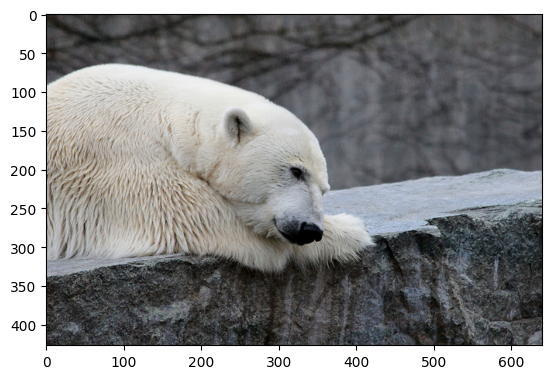

In [55]:
plt.imshow(retrieve_image(v['image']))

  0%|          | 0/5 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Next token: 
 Confidence: 0.0507233701646328
Next token: The Confidence: 0.037964146584272385
Next token:  first Confidence: 0.009784030728042126
Next token:  thing Confidence: 0.06265196204185486
Next token:  you Confidence: 0.2576608657836914
Does the animal appear to be agitated? <|endoftext|>
The first thing you


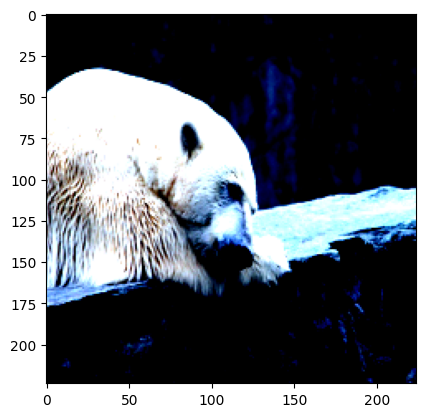

In [56]:
trained_model1 = trained_model1.to(device)
image, outputs, processed_image = trained_model1.generate(v['image'], [v['question']], max_text_length=5)
# plt.imshow(image)
plt.imshow(processed_image.squeeze(0).permute(1, 2, 0))